In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import GPyOpt, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from GPy import kern


# RNASEQ Data

In [2]:
%run load_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
data = rnaseq_all_genes
design = rnaseq_design

In [4]:
from paramz import Model, Param

In [5]:
class ParamzLogReg(Model):
    def __init__(self, X, y, C=1., rep= 1,name='ParamzLogReg'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzLogReg, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.link_parameter(self.C)
        self.sk = [(tr_idx,test_idx) for tr_idx,test_idx in StratifiedKFold(train_labels, shuffle=True) for _ in range(rep)]
        
    def parameters_changed(self):
        from sklearn.metrics import accuracy_score
    
        self._acc = 0.
    
        for train_index, test_index in self.sk:
            rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
            rfc = rfc.fit(self.X[train_index], self.y[train_index])
            prediction = rfc.predict(self.X[test_index])
            self._acc += accuracy_score(self.y[test_index], prediction)/float(len(self.sk))
            
    def objective_function(self):
        import numpy as np
        print self._acc
        return -np.atleast_1d(self._acc)

In [6]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx

In [7]:
train_set = data.loc[:, train_idx]
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
train_set[:] = normalizer.fit_transform(train_set.T).T

test_set = data.loc[:, test_idx]
test_set[:] = normalizer.transform(test_set.T).T

In [8]:
train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [9]:
m = ParamzLogReg(train_set.T.values, train_labels.values, rep=1)

In [10]:
def f(X):
    ret = np.empty((X.shape[0],1))
    for i in range(X.shape[0]):
        ret[i] = m._objective(X[i])
    return ret
mixed_domain =[{'name': 'C', 'type': 'continuous', 'domain':(0,10)}]

m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            domain=mixed_domain,        # box-constrains of the problem
                                            initial_design_numdata = 10, # number data initial design
                                            kernel= kern.Matern32(input_dim=1, variance=.5, lengthscale=5) + kern.Bias(1),
                                            acquisition='LP',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

0.984126984127
0.920634920635
0.951587301587
0.984126984127
0.984126984127
0.96746031746
0.96746031746
0.968253968254
0.96746031746
0.96746031746
*Optimization completed.


In [12]:
m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5)

0.96746031746
0.96746031746
0.984126984127
0.96746031746
0.950793650794
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.951587301587
0.96746031746
0.96746031746
0.951587301587
0.984126984127
0.950793650794
0.968253968254
0.951587301587
0.96746031746
0.950793650794
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.951587301587
0.951587301587
0.984126984127
0.984126984127
0.951587301587
0.96746031746
0.96746031746
0.96746031746
0.984126984127
0.96746031746
0.96746031746
0.984126984127
0.96746031746
0.984126984127
0.951587301587
0.96746031746
0.984126984127
0.951587301587
0.96746031746
0.951587301587
0.950793650794
0.96746031746
0.951587301587
0.950793650794
0.96746031746
0.96746031746
0.968253968254
0.951587301587
0.950793650794
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.96746031746
0.96746031746
*Optimization completed.


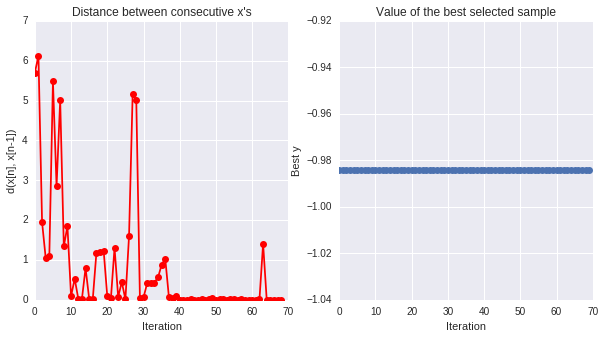

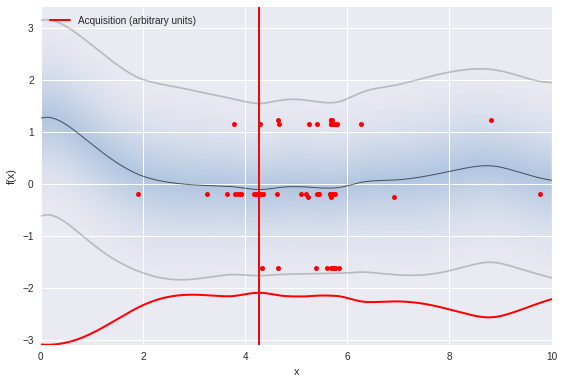

In [13]:
m_opt.plot_convergence()
m_opt.plot_acquisition()

In [14]:
m_opt.x_opt

array([ 5.84330456])

In [15]:
m_opt.kernel

sum.,value,constraints,priors
Mat32.variance,0.365927258267,+ve,
Mat32.lengthscale,1.25069320857,+ve,
bias.variance,7.26008942491e-09,+ve,


In [38]:
lr = LogisticRegression(penalty='l1', C=float(m_opt.x_opt), n_jobs=-1,class_weight='balanced')
lr.fit(train_set.T.values, train_labels.values)
prob_prediction = pd.DataFrame(lr.predict_proba(test_set.T.values), columns=lr.classes_, index=test_set.columns)
prob_prediction['Unknown']=0.
trans = prob_prediction>(1 - 1./6.)
trans.Unknown = np.sum(trans, axis=1) == 0 
prediction = trans.idxmax(axis=1)

In [40]:
trans.head()

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
RNAseq22,True,False,False,False,False,False,False
RNAseq23,False,False,True,False,False,False,False
RNAseq24,False,False,False,False,False,False,True
RNAseq25,False,False,False,False,False,False,True
RNAseq26,False,False,False,False,False,False,True


In [41]:
prediction.head()

RNAseq22     Control
RNAseq23    Effect_2
RNAseq24     Unknown
RNAseq25     Unknown
RNAseq26     Unknown
dtype: object

In [42]:
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,8)]
true_labels = pd.DataFrame(np.zeros((test_labels.shape[0],8)), columns=col, index=test_set.columns)
for ind in test_labels.index:
    true_labels[test_labels[ind]][ind]=1
true_labels['Unknown'] = true_labels['Effect_6'] + true_labels['Effect_7']
del true_labels['Effect_6']
del true_labels['Effect_7']
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,6)] +['Unknown']
print np.sum(true_labels['Effect_3'])
true_labels.head()


0.0


,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
RNAseq22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
RNAseq23,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq24,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq25,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq26,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [44]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(7):
    precision[col[i]], recall[col[i]], _ = precision_recall_curve(true_labels.values[:, i],
                                                        prob_prediction.values[:, i])
    average_precision[col[i]] = average_precision_score(true_labels.values[:, i], prob_prediction.values[:, i])


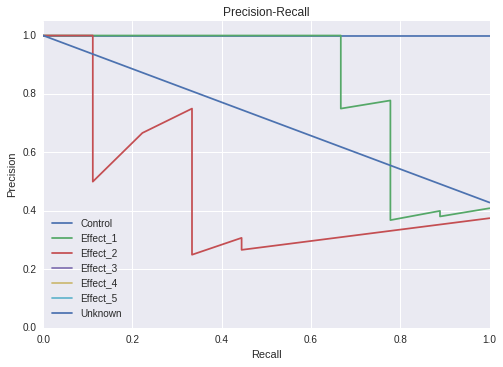

In [45]:
k = col[0]
plt.clf()
for k in col:
    plt.plot(recall[k], precision[k], label='{0}'.format( k))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()


In [46]:
from sklearn.metrics import classification_report, accuracy_score
print classification_report(true_labels.idxmax(axis=1), prediction.values)
print accuracy_score(true_labels.idxmax(axis=1), prediction.values)

             precision    recall  f1-score   support

    Control       1.00      0.83      0.91         6
   Effect_1       1.00      0.22      0.36         9
   Effect_2       0.75      0.33      0.46         9
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.53      0.89      0.67        18

avg / total       0.75      0.62      0.59        42

0.619047619048


In [47]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(true_labels.idxmax(axis=1), prediction, labels= true_labels.columns), columns=true_labels.columns, index=true_labels.columns)

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Control,5,0,0,0,0,0,1
Effect_1,0,2,0,0,0,0,7
Effect_2,0,0,3,0,0,0,6
Effect_3,0,0,0,0,0,0,0
Effect_4,0,0,0,0,0,0,0
Effect_5,0,0,0,0,0,0,0
Unknown,0,0,1,0,1,0,16


# Micro rna

In [2]:
%run load_data.py micro

loading microarray data
micro_all_genes: (13613, 105)
micro_effector_genes: (1044, 105)
micro_mod_activities: (89, 105)
micro_mod_genevals: (201, 105)
micro_mod_nodevals: (462, 105)
micro_signaling_genes: (2184, 105)
micro_design: (105, 4)


In [3]:
data = micro_all_genes
design = micro_design

In [4]:
from paramz import Model, Param

In [5]:
class ParamzLogReg(Model):
    def __init__(self, X, y, C=1., rep= 1,name='ParamzLogReg'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzLogReg, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.link_parameter(self.C)
        self.sk = [(tr_idx,test_idx) for tr_idx,test_idx in StratifiedKFold(train_labels, shuffle=True) for _ in range(rep)]
        
    def parameters_changed(self):
        from sklearn.metrics import accuracy_score
    
        self._acc = 0.
    
        for train_index, test_index in self.sk:
            rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
            rfc = rfc.fit(self.X[train_index], self.y[train_index])
            prediction = rfc.predict(self.X[test_index])
            self._acc += accuracy_score(self.y[test_index], prediction)/float(len(self.sk))
            
    def objective_function(self):
        import numpy as np
        print self._acc
        return -np.atleast_1d(self._acc)

In [6]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx

In [7]:
train_set = data.loc[:, train_idx]
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
train_set[:] = normalizer.fit_transform(train_set.T).T

test_set = data.loc[:, test_idx]
test_set[:] = normalizer.transform(test_set.T).T

In [8]:
train_labels = design.loc[train_idx, 'Drug/Chemical']
test_labels = design.loc[test_idx, 'Drug/Chemical']
test_labels.head()
design.head()

,idx,Drug/Chemical,Effect,Set
SampleID_Microarray,,,,
Array_1,1,Effect_3,Drug/Chemical_1,Training Set
Array_2,2,Effect_3,Drug/Chemical_1,Training Set
Array_3,3,Effect_3,Drug/Chemical_2,Training Set
Array_4,4,Effect_3,Drug/Chemical_2,Training Set
Array_5,5,Effect_3,Drug/Chemical_2,Training Set


In [9]:
m = ParamzLogReg(train_set.T.values, train_labels.values, rep=1)

In [10]:
def f(X):
    ret = np.empty((X.shape[0],1))
    for i in range(X.shape[0]):
        ret[i] = m._objective(X[i])
    return ret
mixed_domain =[{'name': 'C', 'type': 'continuous', 'domain':(0,1000)}]

m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            domain=mixed_domain,        # box-constrains of the problem
                                            initial_design_numdata = 10, # number data initial design
                                            kernel= kern.Matern32(input_dim=1, variance=1000, lengthscale=5) + kern.Bias(1),
                                            acquisition='LP',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

0.587301587302
0.555555555556
0.507936507937
0.444444444444
0.603174603175
0.507936507937
0.492063492063
0.571428571429
0.539682539683
0.52380952381
*Optimization completed.


In [11]:
m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5)

0.52380952381
0.460317460317
0.507936507937
0.539682539683
0.52380952381
0.507936507937
0.507936507937
0.52380952381
0.555555555556
0.507936507937
0.492063492063
0.460317460317
0.492063492063
0.507936507937
0.539682539683
0.52380952381
0.460317460317
0.492063492063
0.571428571429
0.539682539683
0.52380952381
0.507936507937
0.460317460317
0.539682539683
0.52380952381
0.460317460317
0.507936507937
0.492063492063
0.507936507937
0.492063492063
0.539682539683
0.555555555556
0.428571428571
0.507936507937
0.52380952381
0.539682539683
0.539682539683
0.507936507937
0.52380952381
0.492063492063
0.571428571429
0.539682539683
0.539682539683
0.47619047619
0.52380952381
0.539682539683
0.492063492063
0.571428571429
0.555555555556
0.571428571429
0.507936507937
0.539682539683
0.52380952381
0.507936507937
0.444444444444
0.555555555556
0.539682539683
0.507936507937
0.587301587302
0.539682539683
*Optimization completed.


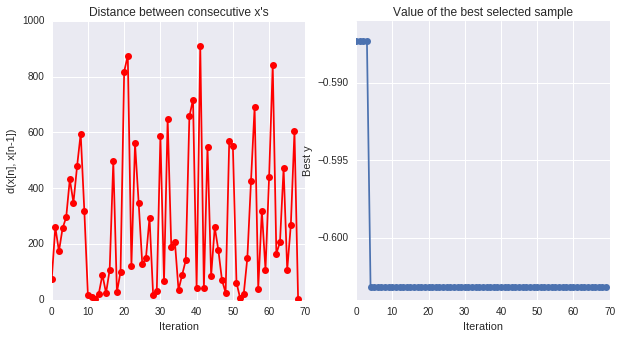

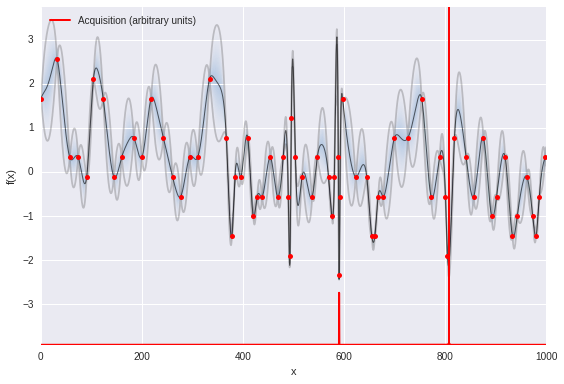

In [12]:
m_opt.plot_convergence()
m_opt.plot_acquisition()

In [14]:
print 1/600.
m_opt.x_opt

0.00166666666667


array([ 590.26149011])

In [15]:
m_opt.kernel

sum.,value,constraints,priors
Mat32.variance,0.999158890763,+ve,
Mat32.lengthscale,19.4086824122,+ve,
bias.variance,1.23195228302e-15,+ve,


In [16]:
lr = LogisticRegression(penalty='l1', C=float(m_opt.x_opt), n_jobs=-1,class_weight='balanced')
lr.fit(train_set.T.values, train_labels.values)
prob_prediction = pd.DataFrame(lr.predict_proba(test_set.T.values), columns=lr.classes_, index=test_set.columns)
prob_prediction['Unknown']=0.
trans = prob_prediction>(1 - 1./6.)
trans.Unknown = np.sum(trans, axis=1) == 0 
prediction = trans.idxmax(axis=1)

In [17]:
trans.head()

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Array_10,False,False,False,True,False,False,False
Array_11,False,False,False,True,False,False,False
Array_12,True,False,False,False,False,False,False
Array_13,True,False,False,False,False,False,False
Array_14,True,False,False,False,False,False,False


In [18]:
prediction.head()

Array_10    Effect_3
Array_11    Effect_3
Array_12     Control
Array_13     Control
Array_14     Control
dtype: object

In [19]:
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,8)]
true_labels = pd.DataFrame(np.zeros((test_labels.shape[0],8)), columns=col, index=test_set.columns)
for ind in test_labels.index:
    true_labels[test_labels[ind]][ind]=1
true_labels['Unknown'] = true_labels['Effect_6'] + true_labels['Effect_7']
del true_labels['Effect_6']
del true_labels['Effect_7']
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,6)] +['Unknown']
print np.sum(true_labels['Effect_3'])
true_labels.head()


0.0


,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Array_10,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_11,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_12,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_13,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_14,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [21]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(7):
    precision[col[i]], recall[col[i]], _ = precision_recall_curve(true_labels.values[:, i],
                                                        prob_prediction.values[:, i])
    average_precision[col[i]] = average_precision_score(true_labels.values[:, i], prob_prediction.values[:, i])


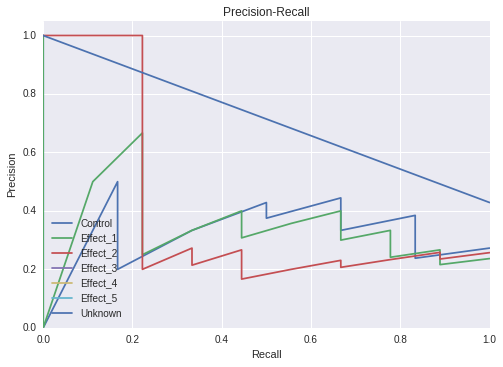

In [22]:
k = col[0]
plt.clf()
for k in col:
    plt.plot(recall[k], precision[k], label='{0}'.format( k))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()


In [23]:
from sklearn.metrics import classification_report, accuracy_score
print classification_report(true_labels.idxmax(axis=1), prediction.values)
print accuracy_score(true_labels.idxmax(axis=1), prediction.values)

             precision    recall  f1-score   support

    Control       0.40      0.67      0.50         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       1.00      0.11      0.20         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.38      0.33      0.35        18

avg / total       0.43      0.26      0.27        42

0.261904761905


In [25]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(true_labels.idxmax(axis=1), prediction, labels= true_labels.columns), columns=true_labels.columns, index=true_labels.columns)

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Control,4,0,0,0,0,0,2
Effect_1,0,0,0,1,1,0,7
Effect_2,5,0,1,2,0,0,1
Effect_3,0,0,0,0,0,0,0
Effect_4,0,0,0,0,0,0,0
Effect_5,0,0,0,0,0,0,0
Unknown,1,1,0,8,0,2,6
